# Import Libraries

In [1]:
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
from src.kappa_constructor import KappaConstructor
from src.info_extractor import InfoExtractor
from src.stats_merger import EllHelper
from src.utils import load_config, filter_config, setup_logging

# Setup the environment

In [67]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
sample_dir = workdir / "data" / "tiled" / "proc2048_nc1024_size625_nsteps60_s121_10tiled"

In [68]:
config = load_config(config_file)
setup_logging()

In [69]:
config_kc = filter_config(config, KappaConstructor)
kc = KappaConstructor(sample_dir, **config_kc)

In [70]:
#kc.compute_kappa()

# Check the output files

In [71]:
kappa_files = sorted(list((sample_dir / "kappa").glob("kappa_zs*_s*.fits")))
zs_list = [InfoExtractor.extract_redshift_from_path(f.stem) for f in kappa_files]
print(zs_list)

[0.5, 1.0, 1.5, 2.0, 2.5]


In [72]:
# downsample the map for the test
nside_test = 512
kappa_maps = []
for f in kappa_files:
    kappa = hp.read_map(f)
    kappa = hp.ud_grade(kappa, nside_out=nside_test, order_in="NESTED", order_out="RING")
    kappa_maps.append(kappa)

2024-10-09 08:43:40,352 - INFO - NSIDE = 8192
2024-10-09 08:43:40,356 - INFO - ORDERING = RING in fits file
2024-10-09 08:43:40,361 - INFO - INDXSCHM = IMPLICIT
2024-10-09 08:44:05,756 - INFO - NSIDE = 8192
2024-10-09 08:44:05,761 - INFO - ORDERING = RING in fits file
2024-10-09 08:44:05,773 - INFO - INDXSCHM = IMPLICIT
2024-10-09 08:44:31,255 - INFO - NSIDE = 8192
2024-10-09 08:44:31,261 - INFO - ORDERING = RING in fits file
2024-10-09 08:44:31,267 - INFO - INDXSCHM = IMPLICIT
2024-10-09 08:44:56,174 - INFO - NSIDE = 8192
2024-10-09 08:44:56,176 - INFO - ORDERING = RING in fits file
2024-10-09 08:44:56,177 - INFO - INDXSCHM = IMPLICIT
2024-10-09 08:45:20,298 - INFO - NSIDE = 8192
2024-10-09 08:45:20,303 - INFO - ORDERING = RING in fits file
2024-10-09 08:45:20,313 - INFO - INDXSCHM = IMPLICIT


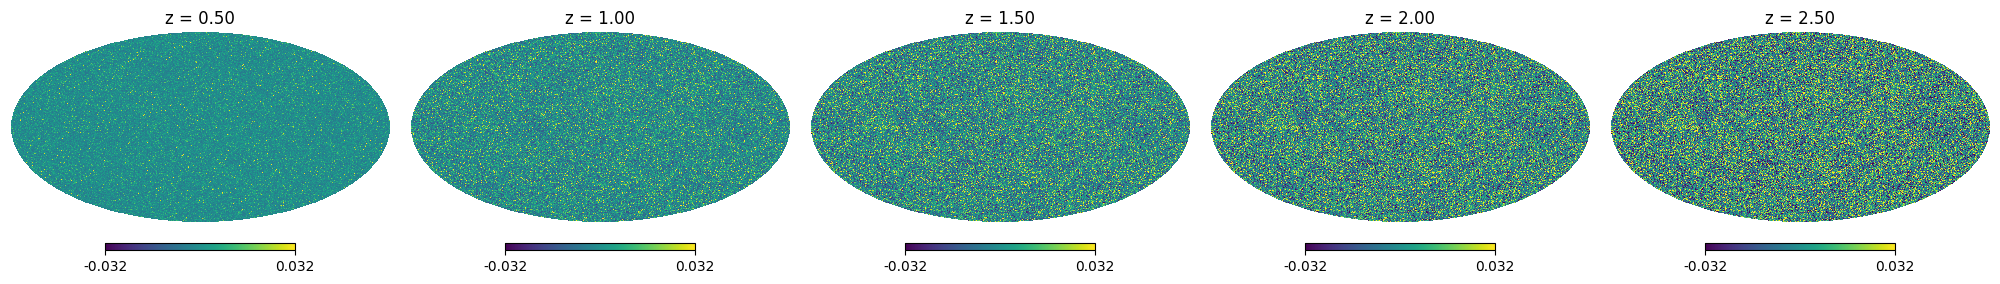

In [73]:
n_maps = len(kappa_files)
fig = plt.figure(figsize=(4 * n_maps, 4))
for i, kappa_file in enumerate(kappa_files):
    zs = InfoExtractor.extract_redshift_from_path(kappa_file.stem)
    hp.mollview(kappa_maps[i], fig=fig.number, sub=(1, n_maps, i + 1), title=f"z = {zs:.2f}", nest=True, min=-0.032, max=0.032)

plt.show()

# Comparison with halofit

In [74]:
clkks = [hp.anafast(kappa_map) for kappa_map in kappa_maps]

In [75]:
halofit_files = sorted(list((workdir / "data" / "halofit").glob("*zs*.npz")))

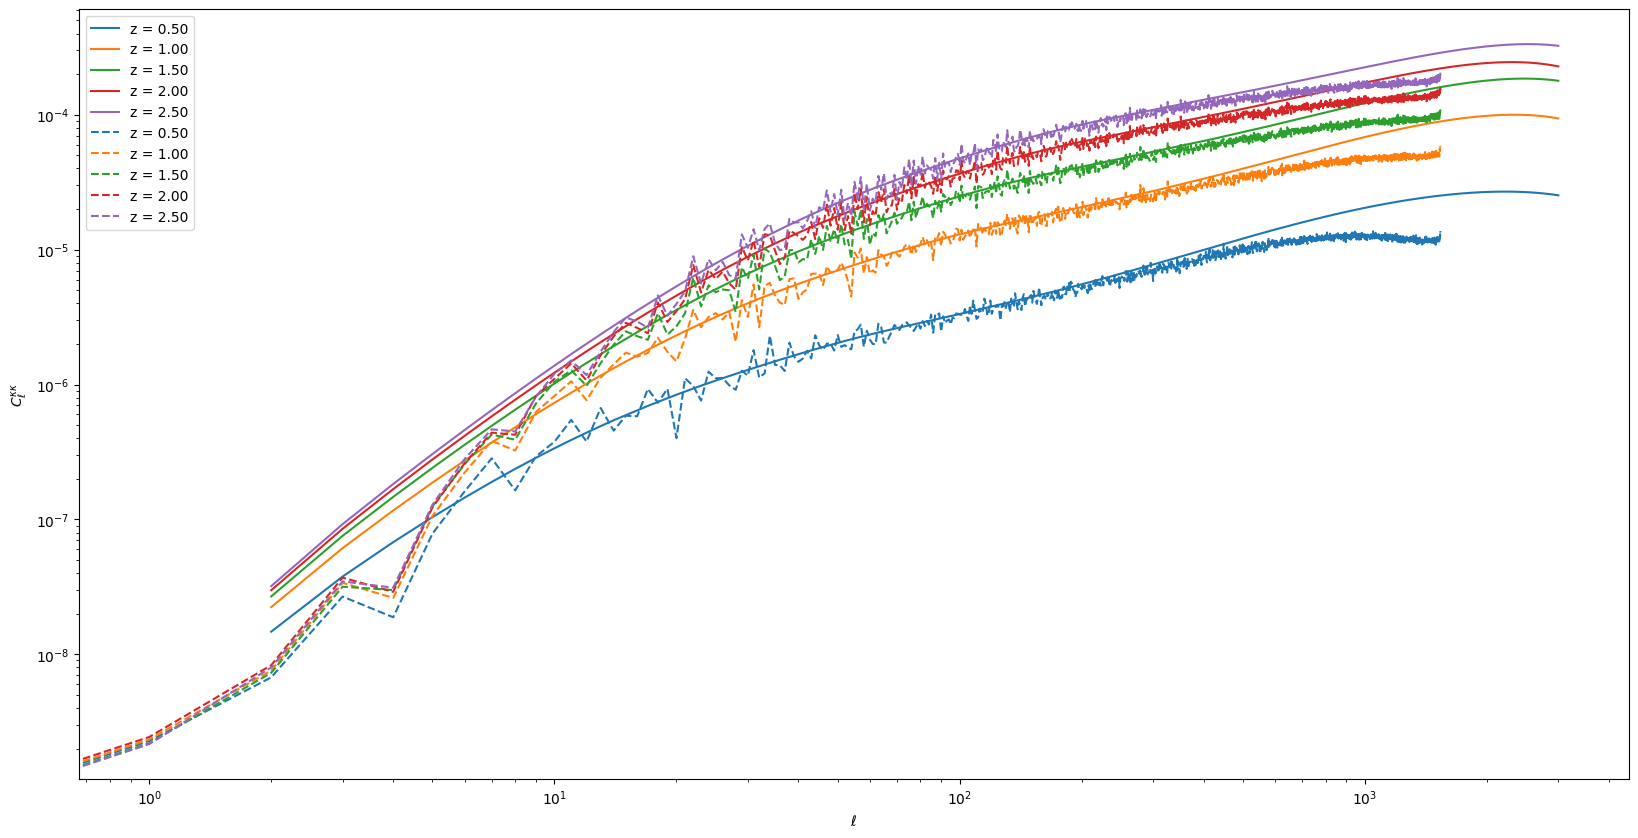

In [76]:
colors = {zs: color for zs, color in zip(zs_list, ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])}

fig = plt.figure(figsize=(20, 10))
for i, halofit_file in enumerate(halofit_files):
    halofit = np.load(halofit_file)
    zs = InfoExtractor.extract_redshift_from_path(halofit_file.stem)
    if zs not in zs_list:
        continue

    dclkk = EllHelper.dimensionless_cl(halofit["clkk"], halofit["ell"])
    plt.plot(halofit["ell"], dclkk, label=f"z = {zs:.2f}", color=colors[zs])

for i, clkk in enumerate(clkks):
    ell = np.arange(len(clkk))
    dclkk = EllHelper.dimensionless_cl(clkk, ell)
    plt.plot(ell, dclkk, label=f"z = {zs_list[i]:.2f}", linestyle="--", color=colors[zs_list[i]])

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_{\ell}^{\kappa\kappa}$")
plt.legend()
plt.show()